In [1]:
#import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import multiprocessing
cores = multiprocessing.cpu_count()
import os
from time import time
import torch
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import pickle

In [ ]:
# To notify when cell is complete (comment out first line). Add %%notify to the first line of a cell to get notified
# !pip uninstall jupyternotify -y
!pip install git+https://github.com/cphyc/jupyter-notify.git
%reload_ext jupyternotify

In [3]:
# read in cleaned CSV
filepath = Path('../massive.csv')
massive = pd.read_csv(filepath)
massive = massive.sample(n=16000)
massive.reset_index(drop=True, inplace=True)

### Pre-processing

In [4]:
# Dropping columns including audienceScore because it could unfairly help the model predict the delta. Leaving tomatoMeter to give the model a base of where the delta could be.
massive = massive.drop(columns=['id', 'reviewId', 'creationDate', 'isTopCritic', 'reviewState', 'audienceScore'])
massive.head(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta
0,Fractured,59.0,Scott Phillips,The Screen Scene,"It's not bad, but it's not particularly good. ...",NEGATIVE,8.0


In [99]:
massive.head(5)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category
0,Fractured,59.0,Scott Phillips,The Screen Scene,"It's not bad, but it's not particularly good. ...",NEGATIVE,8.0,2
1,Sherlock Holmes,69.0,Matthew Turner,ViewLondon,Sherlock Holmes is a surprisingly enjoyable ac...,POSITIVE,-8.0,2
2,Lilo & Stitch 2: Stitch Has a Glitch,40.0,Willie Waffle,WaffleMovies.com,"After a rough start, Lilo and Stitch 2 finally...",POSITIVE,-16.0,1
3,Dracula: Pages From a Virgin's Diary,87.0,Liz Braun,Jam! Movies,The visuals are stunning. The concept is clever.,POSITIVE,14.0,3
4,Gran Torino,81.0,Robert Roten,Laramie Movie Scope,He goes out as a hero. He can be forgiven if h...,POSITIVE,-9.0,2


In [5]:
# Binning delta column into 5 categories for Logistic regression
bins = [-99, -26, -11, 10, 25, 99]
labels = [0, 1, 2, 3, 4]
massive['delta_category'] = pd.cut(massive['delta'], bins=bins, labels=labels)

In [6]:
massive.isnull().sum()

title             0
tomatoMeter       0
criticName        0
publicatioName    0
reviewText        0
scoreSentiment    0
delta             0
delta_category    0
dtype: int64

In [7]:
# Dropping duplicates
massive = massive.drop_duplicates(subset='reviewText', keep='first')
# Resetting index after dropping dupe's
massive.reset_index(drop=True, inplace=True)
# Checking for duplicates
dup_df = massive.apply(lambda x: x.duplicated()).sum()
dup_df

title              7967
tomatoMeter       15880
criticName        12766
publicatioName    14447
reviewText            0
scoreSentiment    15979
delta             15860
delta_category    15976
dtype: int64

## Adding Athen picks (high delta outliers)

In [8]:
# Loading full massive df without samples, sorting, picking top 20 and bottom 20 delta entries
massive_full = pd.read_csv(filepath)
massive_full_sort = massive_full.sort_values(by='delta')
massive_full_asc = massive_full_sort.head(2500)
massive_full_desc = massive_full_sort.tail(2500)
# Combine most positive and most negative delta dataframes
massive_outliers = pd.concat([massive_full_asc, massive_full_desc], ignore_index=True)

In [9]:
# Create a list of titles from massive
existing_titles = massive['title'].tolist()
# Use isin() function to check if titles in massive_outliers exist in massive
mask = massive_outliers['title'].isin(existing_titles)
# Filter massive_outliers to keep only rows that don't exist in massive
massive_outliers = massive_outliers[~mask]

In [11]:
# Running above pre-processing code for massive_outliers
massive_outliers = massive_outliers.drop(columns=['id', 'reviewId', 'creationDate', 'isTopCritic', 'reviewState', 'audienceScore'])
# Binning delta column into 5 categories for Logistic regression
massive_outliers['delta_category'] = pd.cut(massive_outliers['delta'], bins=bins, labels=labels)

In [12]:
# Append outliers to bottom of massive to feed model some outlier data
massive_merge = pd.concat([massive, massive_outliers], ignore_index=True)

In [13]:
massive_merge.tail(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category
19548,Knock Down the House,99.0,CJ Sheu,Critics at Large,If only the film had expanded this focus [on A...,NEGATIVE,88.0,4


## Adding Selected Movies Curated by Jim

In [14]:
# Grabbing reviews for Karen from massive full
Karen = massive_full[massive_full['title'] == 'Karen'].copy()
Karen.reset_index(drop=True, inplace=True)
Karen = Karen.drop(columns=['id', 'reviewId', 'creationDate', 'isTopCritic', 'reviewState', 'audienceScore'])
# Binning delta column into 5 categories for Logistic regression
Karen['delta_category'] = pd.cut(Karen['delta'], bins=bins, labels=labels)
Karen.head(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category
0,Karen,17.0,Keith Garlington,Keith & the Movies,You can&#8217;t miss its bludgeoning message w...,NEGATIVE,-2.0,2


In [16]:
# Create a list of titles from massive
existing_titles = massive['title'].tolist()
# Use isin() function to check if titles in massive_outliers exist in massive
mask = Karen['title'].isin(existing_titles)
# Filter massive_outliers to keep only rows that don't exist in massive
Karen = Karen[~mask]

In [ ]:
# Manually copied reviews from rottentomatoes.com by Jim
extract = pd.read_csv('extract.csv')
extract['delta_category'] = pd.cut(extract['delta'], bins=bins, labels=labels)
column_order = ['title', 'tomatoMeter', 'criticName', 'publicatioName', 'reviewText', 'scoreSentiment', 'delta', 'delta_category']
extract = extract[column_order]
extract

In [ ]:
massive_merge[massive_merge['title'] == 'Jigsaw']

## BERT Vectorizer

In [19]:
# Pulling BERT from huggingface
tokenizer = AutoTokenizer.from_pretrained("activebus/BERT_Review")
model = AutoModel.from_pretrained("activebus/BERT_Review")

Some weights of the model checkpoint at activebus/BERT_Review were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
%%notify
# Text preprocessing function
def preprocess(text):
    # Replace &#8217; and &#44; with an empty string
    cleaned_text = text.replace("&#8217;", "")
    cleaned_text = cleaned_text.replace("&#44;", "")
    # Split the cleaned text into tokens
    tokens = cleaned_text.split(" ")
    # Remove empty tokens
    tokens = [t for t in tokens if t]
    # Join the cleaned tokens back together
    cleaned_text = " ".join(tokens)
    return cleaned_text

# Function to vectorize text with BERT
def get_embedding(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    features = model(**encoded_input)
    features = features[0].detach().numpy() 
    features_mean = np.mean(features[0], axis=0) 
    return features_mean
# Applying the function to reviewText and outputting to embeddings column
Karen['embeddings'] = Karen.reviewText.map(lambda x: get_embedding(x))
extract['embeddings'] = extract.reviewText.map(lambda x: get_embedding(x))
massive_merge['embeddings'] = massive_merge.reviewText.map(lambda x: get_embedding(x))
Karen.head(2)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category,embeddings
0,Karen,17.0,Keith Garlington,Keith & the Movies,You can&#8217;t miss its bludgeoning message w...,NEGATIVE,-2.0,2,"[-0.47593927, 0.72280616, -0.01203326, -0.0237..."
1,Karen,17.0,Jordan Elizabeth,Common Sense Media,Karen is a kitschy representation of a very re...,NEGATIVE,-2.0,2,"[-0.14955108, 0.226287, -0.19022815, -0.315930..."


<IPython.core.display.Javascript object>

In [29]:
massive_merge.iloc[19549:19550] #17830 is first Karen entry

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category,embeddings
19549,Karen,17.0,Keith Garlington,Keith & the Movies,You can&#8217;t miss its bludgeoning message w...,NEGATIVE,-2.0,2,"[-0.47593927, 0.72280616, -0.01203326, -0.0237..."


In [96]:
massive_merge.tail(1)

,tomatoMeter,delta_category,"title_""Sr.""",title_#Unfit: The Psychology of Donald Trump,title_$upercapitalist,title_(500) Days of Summer,title_(Untitled),title_*batteries not Included,title_1,title_1-800-Hot-Nite,...,publicatioName_eFilmCritic.com,publicatioName_film-authority.com,publicatioName_indieWire,publicatioName_jackiekcooper.com,publicatioName_jimschembri.com,publicatioName_rachelsreviews.net,publicatioName_rec.arts.movies.reviews,publicatioName_sbs.com.au,scoreSentiment_NEGATIVE,scoreSentiment_POSITIVE
19601,83.0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [23]:
# Append Karen and extract to bottom of massive merge, will later use them as test data
massive_merge = pd.concat([massive_merge, Karen], ignore_index=True)
massive_merge = pd.concat([massive_merge, extract], ignore_index=True)

In [31]:
# Converting embeddings column to numpy array
vectors = np.array(massive_merge.embeddings.tolist(), dtype='float')
vectors[:10]

array([[-0.43389595,  0.34827933, -0.2383406 , ..., -0.19308986,
         0.16802344,  0.09420886],
       [-0.14234835,  0.07326289,  0.20431201, ..., -0.00971311,
         0.40391847, -0.03476195],
       [-0.16884245,  0.16325556,  0.21106704, ..., -0.06948403,
         0.40979126,  0.01262082],
       ...,
       [-0.40600485,  0.47996828, -0.06811081, ..., -0.00080269,
         0.32329607,  0.08391051],
       [-0.05602273,  0.62315124, -0.15400185, ..., -0.25609121,
         0.44035068,  0.13438614],
       [-0.25505507,  0.55469555, -0.07458504, ..., -0.13576549,
         0.2006789 , -0.00410696]])

In [32]:
# Flattening numpy array and creating dataframe with it
v_df = pd.DataFrame(vectors, columns=[f'col{i+1}' for i in range(vectors.shape[1])])
v_df.tail(2)

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
19600,0.052963,0.162317,0.125751,-0.098146,0.011355,-0.224838,0.154928,0.506497,-0.009151,-0.691070,...,0.058181,0.066088,-0.074512,-0.050494,0.053227,-0.017694,-0.010848,-0.236267,0.308740,0.084204
19601,-0.208760,0.327155,0.229765,-0.184427,0.071725,-0.157181,0.099763,0.565991,-0.044930,-0.406662,...,0.044122,-0.092793,0.179549,-0.047291,-0.162539,-0.181654,0.363411,-0.151188,0.146897,-0.001422


In [33]:
# Dropping review text now it is vectorized, and dropping embeddings now that it is flattened
massive_merge = massive_merge.drop(columns=['reviewText', 'embeddings', 'delta'])

In [34]:
massive_merge.isnull().sum().head(9)

title             0
tomatoMeter       0
criticName        0
publicatioName    0
scoreSentiment    0
delta_category    0
dtype: int64

### Encoding categorical columns

In [36]:
# Renaming the least-appearing critics as Other to later be encoded as the same critic
counts = massive_merge.criticName.value_counts()
threshold = massive_merge.criticName.isin(counts.index[counts<16])
massive_merge.loc[threshold, 'criticName'] = 'Other'
massive_merge['criticName'].value_counts()

Other                10449
Dennis Schwartz        145
Roger Moore            130
David Nusair           123
Roger Ebert            104
                     ...  
Gary Goldstein          16
Jake Wilson             16
Chris Hicks             16
Henry Fitzherbert       16
Keshav Kant             16
Name: criticName, Length: 307, dtype: int64

In [37]:
# Repeat for publications
counts = massive_merge.publicatioName.value_counts()
threshold = massive_merge.publicatioName.isin(counts.index[counts<12])
massive_merge.loc[threshold, 'publicatioName'] = 'Other'
massive_merge['publicatioName'].value_counts()

Other                           4265
New York Times                   277
Variety                          220
Los Angeles Times                209
Village Voice                    181
                                ... 
The Skinny                        12
The Dispatch (Lexington, NC)      12
The Hollywood Outsider            12
MSN Movies                        12
Marvelous Geeks Media             12
Name: publicatioName, Length: 435, dtype: int64

In [38]:
# List of columns to dummy
categorical_cols = ['title', 'criticName', 'publicatioName', 'scoreSentiment'] 
# Get dummies on categorical columns
massive_merge = pd.get_dummies(massive_merge, columns = categorical_cols)

### Final pre-processing, splitting, scaling, PCA

In [39]:
# Joining massive df with vectorized df
combined = pd.concat([massive_merge, v_df], axis=1)
combined.tail(1)

,tomatoMeter,delta_category,"title_""Sr.""",title_#Unfit: The Psychology of Donald Trump,title_$upercapitalist,title_(500) Days of Summer,title_(Untitled),title_*batteries not Included,title_1,title_1-800-Hot-Nite,...,col759,col760,col761,col762,col763,col764,col765,col766,col767,col768
19601,83.0,4,0,0,0,0,0,0,0,0,...,0.044122,-0.092793,0.179549,-0.047291,-0.162539,-0.181654,0.363411,-0.151188,0.146897,-0.001422


In [40]:
# Splitting train and test from combined dataframe by bottom rows
# Gathering total rows of combined
total_rows = len(combined)
# Number of rows to keep for training (all except the last n, which are from Athen & Jim picks)
train_rows = total_rows - 53
# Splitting Train from massive df and Test from massive_outliers
combined_main = combined.iloc[:train_rows, :]
combined_val = combined.iloc[train_rows:, :]

In [47]:
# Splitting X and y
X = combined_main.drop(columns=['delta_category'])
y = combined_main['delta_category']

In [48]:
# Splitting X and y
X_val = combined_val.drop(columns=['delta_category'])
y_val = combined_val['delta_category']
# Converting Category datatype to integer
y_val = y_val.cat.codes

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train = y_train.cat.codes
y_test = y_test.cat.codes

In [50]:
X_train.isnull().sum().sum()

0

In [51]:
y_train[:5]

4787     2
9696     3
17476    0
5849     3
7285     1
dtype: int8

In [52]:
%%notify
# Scaling X
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

<IPython.core.display.Javascript object>

In [53]:
%%notify
# PCA to filter most important features
pca = PCA(n_components=6000)
X_train_p = pca.fit_transform(X_train_sc)
X_test_p = pca.transform(X_test_sc)

<IPython.core.display.Javascript object>

In [54]:
X_val_sc = sc.transform(X_val)
X_val_p = pca.transform(X_val_sc)

## Logistic Regression

In [55]:
%%notify
# Training learning model
model = LogisticRegression(max_iter=5000)
model.fit(X_train_p, y_train)

LogisticRegression(max_iter=5000)

<IPython.core.display.Javascript object>

In [56]:
model.score(X_train_p, y_train)

1.0

In [57]:
model.score(X_test_p, y_test)

0.8238543371522095

In [62]:
y_pred = model.predict(X_test_p)

In [58]:
# Predicting the 52 samples curated by Jim
y_val_pred = model.predict(X_val_p)
y_val_pred

array([2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 4, 2, 2, 1, 2, 4, 0, 2, 2,
       2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int8)

In [60]:
# Actual targets. Lots of correct guesses for Karen
y_val_test = np.array(y_val)
y_val_test

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int8)

In [71]:
Karen.head(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category,embeddings
0,Karen,17.0,Keith Garlington,Keith & the Movies,You can&#8217;t miss its bludgeoning message w...,NEGATIVE,-2.0,2,"[-0.47593927, 0.72280616, -0.01203326, -0.0237..."


In [70]:
extract.head(1)

,title,tomatoMeter,criticName,publicatioName,reviewText,scoreSentiment,delta,delta_category,embeddings
0,Sound of Freedom,57,Maria Latilla,WhyNow,Sound of Freedom arrives in UK cinemas with a ...,NEGATIVE,-42.0,0,"[0.093633525, 0.19919057, 0.106464155, -0.2038..."


In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       597
           1       0.90      0.65      0.76       529
           2       0.77      0.94      0.85      2332
           3       0.91      0.62      0.74       903
           4       0.82      0.82      0.82       527

    accuracy                           0.82      4888
   macro avg       0.87      0.77      0.81      4888
weighted avg       0.84      0.82      0.82      4888



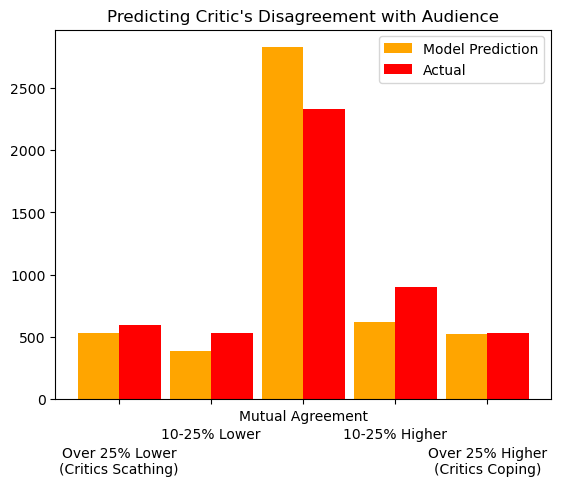

In [90]:
x = np.arange(5)

bar_width = 0.45

# Create bar graphs for y_pred and y_test
plt.bar(x - bar_width/2, np.bincount(y_pred), bar_width, label='Model Prediction', color='orange', align='center')
plt.bar(x + bar_width/2, np.bincount(y_test), bar_width, label='Actual', color='red', align='center')

plt.title("Predicting Critic's Disagreement with Audience")
custom_labels = ['Over 25% Lower\n(Critics Scathing)', '10-25% Lower', 'Mutual Agreement', '10-25% Higher', 'Over 25% Higher\n(Critics Coping)']
plt.xticks(x, custom_labels, rotation=0)
xtick_labels = plt.gca().get_xticklabels()
xtick_labels[0].set_y(-0.1)  # Adjust the y-position
xtick_labels[-1].set_y(-0.1)
xtick_labels[1].set_y(-0.049)
xtick_labels[3].set_y(-0.049)
plt.legend()
plt.savefig('BERT_categorical_pred_vs_test.png')
plt.show()

In [ ]:
# Saving model
with open('BERT_categorical_outliers_model.pkl', 'wb') as file:
    pickle.dump(model, file)

## Random Forest Classifier

In [ ]:
%%notify
f_cores = cores-10
fmodel = RandomForestClassifier(n_estimators=50, n_jobs=f_cores, random_state=30)
fmodel.fit(X_train_p, y_train)

In [ ]:
fmodel.score(X_train_p, y_train)

In [ ]:
fmodel.score(X_test_p, y_test)

## SVM Classifier (SVC)

In [ ]:
# Running in GBTree notebook
""""%%notify
param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf', 'poly'],
    #'epsilon': [0.1, 0.2, 0.5], # For regression models
    'gamma': ['scale', 'auto']  # For RBF kernel
}
svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=5)

grid_search.fit(X_train_p, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_p)""""

In [ ]:
best_model.score(X_train_p, y_train)

In [ ]:
best_model.score(X_test_p, y_test)